# Plot of first run of `ota-basic.py`

These experiments were run overnight on 6–7 July 2021 NZST (overnight 5–6 July PDT). They're the first nontrivial run of the over-the-air experiments. I'm not expecting them to say much, but hopefully they offer something not too unexpected.

In [1]:
import csv
import json
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results_location = Path("../results-downloaded/ota-basic-1")

# Training by round

First, let's just pick a few cases at random and plot the training graphs for them.

In [2]:
def get_args(directory):
    argsfile = directory / 'arguments.json'
    with open(argsfile) as f:
        content = json.load(f)
    return content['args']

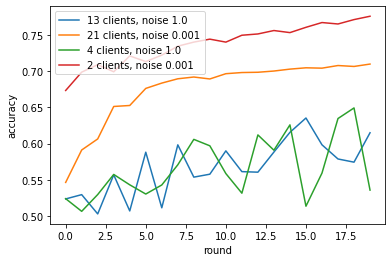

In [3]:
directories = random.sample(list(results_location.iterdir()), 4)

for directory in directories:
    args = get_args(directory)
    clients = args['clients']
    noise = args['noise']

    training = pd.read_csv(directory / "training.csv")
    training["accuracy"].plot(label=f"{clients} clients, noise {noise}", xlabel="round", ylabel="accuracy")

plt.legend()

Seems like all the low-noise cases did better than all the high-noise cases. That seems promising. Is that right? In the below plot, blue (`'C0'`) lines are $\sigma_\mathrm{n}^2 = 0.001$, and orange (`'C1'`) lines are $\sigma_\mathrm{n}^2 = 1.0$.

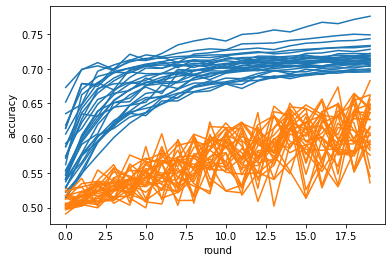

In [4]:
for directory in results_location.iterdir():
    args = get_args(directory)
    noise = args['noise']
    color = 'C1' if noise == 1.0 else 'C0'
    training = pd.read_csv(directory / "training.csv")
    training["accuracy"].plot(ylabel="accuracy", xlabel="round", color=color)

Seems pretty legit. Notice also that the high-noise cases jump around heaps, but do improve eventually. This also seems consistent with what we'd expect.

# Test accuracy vs clients

In [5]:
def get_eval(directory):
    argsfile = directory / 'evaluation.json'
    with open(argsfile) as f:
        content = json.load(f)
    return content

In [6]:
clients_range = range(2, 31)
noise_levels = [0.001, 1.0]
fields = ["accuracy", "snr", "avg_power", "test_loss"]
columns = pd.MultiIndex.from_product((fields, noise_levels))

results = pd.DataFrame(index=clients_range, columns=columns)

for directory in results_location.iterdir():
    args = get_args(directory)
    clients = args['clients']
    noise = args['noise']
    
    evaluation = get_eval(directory)
    for field in fields:
        results.loc[clients, (field, noise)] = evaluation[field]

<AxesSubplot:xlabel='clients', ylabel='accuracy'>

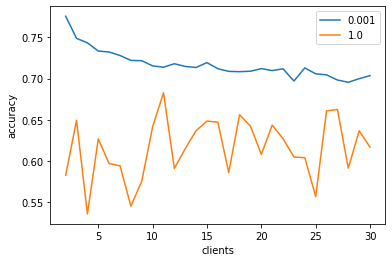

In [7]:
results["accuracy"].plot(xlabel="clients", ylabel="accuracy")

Okay, that's interesting—it seems to go better with _fewer_ clients. This is the opposite of what we should expect. What's going on?

One issue is that the quality of our "data"—in this case, the local model parameters—gets worse as we have more clients, because each client has less data (because the data is split up among clients). The easy way around this is to divide the data ahead of time into the largest number of clients we intend to test, and then only use some of the data when there are fewer clients.

But possibly the bigger problem is that our SNR function is actually a function of the number of clients:

<AxesSubplot:xlabel='clients', ylabel='SNR'>

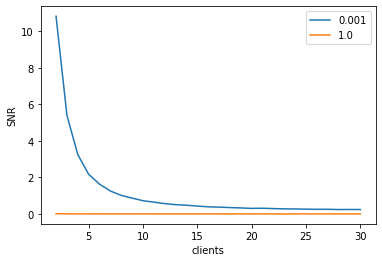

In [8]:
results["snr"].plot(xlabel="clients", ylabel="SNR")

Huh, let's zoom in:

<AxesSubplot:xlabel='clients', ylabel='accuracy'>

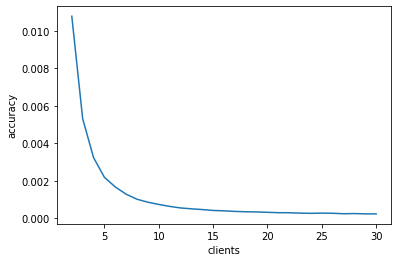

In [9]:
results[("snr", 1.0)].plot(xlabel="clients", ylabel="accuracy")

Forget about noise, what about just plotting the average power?

<AxesSubplot:xlabel='clients', ylabel='average power'>

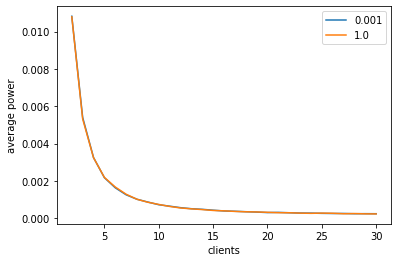

In [10]:
results["avg_power"].plot(xlabel="clients", ylabel="average power")

What the what? There's no division by the number of clients, and the symbols being transmitted are the model state. (The field `avg_power` reflects the average power coming out of a transmitter, not the total power in the system, so there's no multiplication by the number of clients, either.)

Questions:
- Is the average power a function of round number?
- What are the final model states?

These are kind of things I wish I had logged.